In [11]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
import scipy as sp
import pandas as pd
import pickle

import path
path.path = path.Path
#from statsmodels.distributions.empirical_distribution import ECDF
from pyqt_fit import kde
#,pyqt_fit.kde_methods

# i/ Rotational Period

In [2]:
def Rotation_Period(Radius, vsini, Radius_err_l, vsini_err_l, Radius_err_h=None, vsini_err_h=None):
    """
    Function to estimate the rotational period with errors 
    
    Parameters:
    Radius (R_jup)
    vsini  (km /s)
    Radius_err_l
    vsini_err_l
    
    Returns:
    - P       (float) : Period in hours
    - P_err_h (float) : Period upper limit in hours
    - P_err_l (float) : Period lower limit in hours
    """
    P = 2 * np.pi * Radius * u.Rjup / (vsini * u.km / u.s)
    P_err_l = P * np.sqrt((Radius_err_l / Radius)**2 + (vsini_err_l / vsini)**2)
    
    if Radius_err_h == None or vsini_err_h == None:
        P_err_h = P_err_l
    else:
        P_err_h = P * np.sqrt((Radius_err_h / Radius)**2 + (vsini_err_h / vsini)**2)
        
    return P.to(u.hr), P_err_h.to(u.hr), P_err_l.to(u.hr) 

In [3]:
# AB Pic b Rotational period from B7 best fit

Period, P_h, P_l = Rotation_Period(1.7, 73, Radius_err_l=-0.1, vsini_err_l=-27, Radius_err_h=0.8, vsini_err_h=11)
print('P_rot = '+str(Period)+' + '+str(P_h)+' - '+str(P_l))


P_rot = 2.9057675904395017 h + 1.435811587794206 h - 1.0882433513349463 h


# ii/ Break-up rotational velocity

In [4]:
# break-up velocity: Fuerza Centrifuga vs Gravitacional

vel_breakup = np.sqrt(c.G * 10*u.Mjup / (1.7* u.Rjup))
vel_breakup = vel_breakup.to(u.km/u.s)

print('V_breakup = '+ str(vel_breakup))
print('AB Pic b is orbiting at '+str(73*(u.km/u.s)/vel_breakup)+'% of its break-up velocity')


V_breakup = 102.09677791738046 km / s
AB Pic b is orbiting at 0.7150078728152774% of its break-up velocity


# iii/ Orbital inclination / Obliquity derivation

We found the publication of Zhou et al. (2019) where through the lightcurve variability they estimate the rotation period of AB Pic b to be 2.1 hr.

https://iopscience.iop.org/article/10.3847/1538-3881/ab037f/pdf

Since there is already a reliable estimation on the rotation period, the previouse estimations are not the key parameter we can push. We decided to go for the obliquity of the planet, given our vsini value and the P_rotation from Zhou

For this we follow the procedure showed in Bryan et al. (2021), section 3.5.

https://doi.org/10.3847/1538-3881/ac1bb1

##### I try to do this in 2 ways. 


### a/ From the equation for rotation period but with known period...

You can observe that the previouse part gives a flat distribution which doesn't make sense, therefore we tried this second approach.

In [14]:
# FIRST THE IMPORT OF THE DATA 

# posteriors B7 fit (Radius and vsini)
file = '/Users/pulux/Desktop/exoAtmospheres/code_exoAtm/data/result_nestle_ABPicb_B7.pic'

with open(file, 'rb') as f:
    res  = pickle.load(f)
    samp = res.samples
    weig = res.weights
    
vsini  = samp[:,6] *u.km/u.s    
Radius = samp[:,4] *u.Rjup
Prot_lc = 2.12 * u.hr

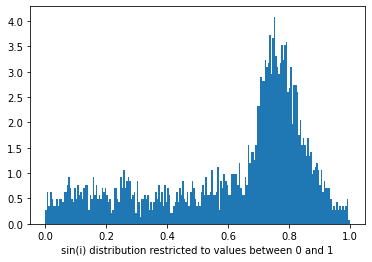

/var/folders/8z/7v6zvrh56pv_bj45q5fh34540000gn/T/ipykernel_85543/4163927435.py:10: RuntimeWarning: invalid value encountered in arcsin
  angles = np.arcsin(sin_i.value)*180/np.pi


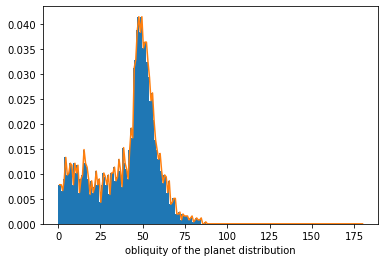

inc_planet ~ 46.800000000000004


In [15]:
# computing sin(i) distribution

sin_i = (vsini/(2*np.pi*Radius/Prot_lc)).si

plt.hist(sin_i,bins=200, density=True, range=(0,1))
plt.xlabel('sin(i) distribution restricted to values between 0 and 1')
plt.show()

# converting to angles
angles = np.arcsin(sin_i.value)*180/np.pi

angles_density, angles_bins, patches = plt.hist(angles,bins=200, density=True,range=(0,180))
plt.plot(angles_bins[1:],angles_density)
plt.xlabel('obliquity of the planet distribution')
plt.show()

# geting the maximal value out
bin_max = np.where(angles_density == angles_density.max())
inc_planet = angles_bins[bin_max]
print('inc_planet ~',inc_planet[0])


### b/ The way they follow in the publication

But here I have seriouse doubts on my implementation... it doesn't make sense. I'm multiplying a uniform distribution by a numer (which comes from the integral in velocity)...

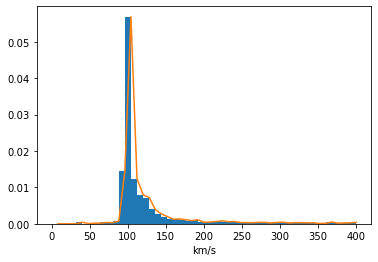

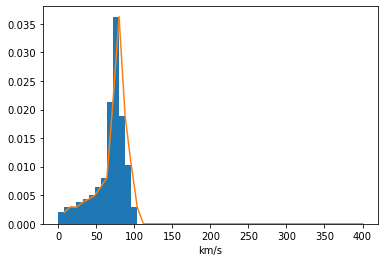

In [16]:

# velocity density distribution -> Lv
Lv = 2 * np.pi * Radius / (Prot_lc)
Lv = Lv.to(u.km / u.s)
Lv_density, Lv_bins, patches = plt.hist(Lv.value, bins=50, density=True, range=(0,400))
plt.plot(Lv_bins[1:],Lv_density)
plt.xlabel('km/s')
plt.show()

# Proyected velocity density distribution -> Lu
Lu=vsini
Lu_density, Lu_bins, patches = plt.hist(vsini, bins=50, density=True, range=(0,400))
plt.plot(Lu_bins[1:],Lu_density)
plt.xlabel('km/s')
plt.show()

In [17]:
names = ['Teff', 'logg', '[M/H]', 'C/O', 'Rjup', 'RV', 'vsini', 'limbdark']
df = pd.DataFrame(res.samples, columns=names)
df['weights'] = res.weights
df.to_csv('/Users/pulux/Desktop/exoAtmospheres/code_exoAtm/data/result_nestle_ABPicb_B7.txt', index=None, sep=' ')

In [18]:
res.samples

array([[ 1.97159464e+03,  3.96873528e+00,  4.54866966e-01, ...,
         7.54736000e+01,  5.26822986e+01,  8.46501392e-02],
       [ 1.99260302e+03,  3.89248533e+00,  5.93404005e-01, ...,
        -6.26192236e+00,  8.97749647e+01,  4.38554487e-01],
       [ 1.81183484e+03,  4.82027779e+00,  4.06159973e-01, ...,
         4.76053388e+01,  6.59120033e+01,  3.44119227e-01],
       ...,
       [ 1.79892660e+03,  4.01899065e+00,  2.03154130e-01, ...,
         3.76477150e+01,  7.18371161e+01,  4.31344166e-01],
       [ 1.79902026e+03,  3.99267204e+00,  1.90599311e-01, ...,
         2.80577128e+01,  8.18021674e+01,  9.09568337e-01],
       [ 1.80169438e+03,  3.97963491e+00,  2.39407856e-01, ...,
         2.69214899e+01,  6.85698348e+01,  2.21844291e-01]])

In [19]:
# Orbital Spin inclination.

def spin_inc(Lv, Lu, v_breakup, bins=50):
    ''' The function to estimate the distribution of cos(i), where i in the planet inclination
    
    Params
    Lv     : Prob dist for v = 2πR/Prot.   -> ForMoSa + Zhou
    Lu     : Prob distribution for vsin(i) -> I have it from ForMoSA
            u (projected vel) : v sin(i) = v sq(1-cos2(i))
    P_cosi : Uniform between 0 and 1
    Pv     : Uniform between 0 and break-up vel
    
    '''
    
    P_cosi                               = np.random.uniform(low=0.0, high=1.0, size=500)
    P_cosi_density, P_cosi_bins, patches = plt.hist(P_cosi, bins=100, density=True, range=(0,1))
    plt.xlabel('Uniform 0 - 1')
    plt.show()
    
    Pv                                   = np.random.uniform(low=0.0, high=v_breakup, size=1000)
    Pv_density, Pv_bins, patches         = plt.hist(Pv, bins=bins, density=True, range=(0,400))
    plt.xlabel('Break-up velocity distribution (km/s)')
    plt.show()
    
    # argument of the integral
    int_dv = Lv * Lu * Pv_density
    # now integrating
    range_x = np.linspace(0,400,bins)
    integral = np.trapz(int_dv, range_x)
    print('Integral value is: ',integral)
    
    # Final value
    prob = P_cosi_density * integral
    
    return P_cosi_bins[1:], prob

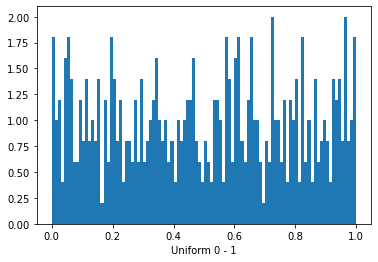

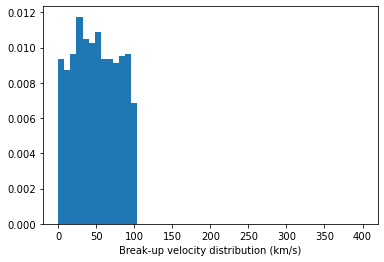

Integral value is:  2.3718800233180087e-05


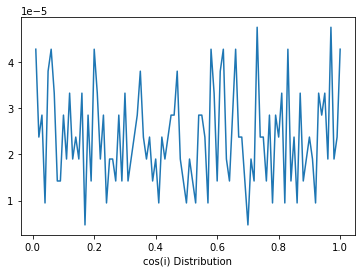

In [20]:
x_bins, prob = spin_inc(Lv_density, Lu_density, vel_breakup.value)


plt.plot(x_bins,prob)
plt.xlabel('cos(i) Distribution')
plt.show()

### c/ For HD 106906b, to test consistency with the publication

In [17]:
HD_vsini = 9.5 *u.km/u.s# ± 0.2 km s−1
HD_R     = 1.49 * u.Rjup #+0.37 R .
HD_Prot  = 4.1 * u.h # ± 0.3 h
sin_i    = (HD_vsini/(2*np.pi*HD_R/HD_Prot)).si
print('sin(i) is ~',sin_i)

# converting to angles
HD_inc   =  np.arcsin(sin_i.value)*180/np.pi
print('Obliquity of the planet distribution is ~', HD_inc)



# in the paper they report a value of ip = 14° ± 4° or 166° ± 4°... more or less consistent...
print('In the paper they report a value of ip = 14° ± 4° or 166° ± 4°')

sin(i) is ~ 0.20950113459304368
Obliquity of the planet distribution is ~ 12.09311906795345
In the paper they report a value of ip = 14° ± 4° or 166° ± 4°


# iv/ Questions 

Obliquity of a planet can change with dynamical interactions?

Does it make sense our derivation of ~48 deg for AB Pic b given a ~ 90 deg inc of the orbital plane.




# v/ True obliquity limits (From Bryan et al.)

In [47]:
# Here I was testing the constraints...

def phi_op(inc_pl, inc_orbit, Omega_pl, Omega_orb):
    arg_1 = np.cos(inc_pl)*np.cos(inc_orbit) 
    arg_2 = np.sin(inc_pl)*np.sin(inc_orbit)*np.cos(Omega_orb-Omega_pl)
    phi_op = np.arccos(arg_1 + arg_2)
    
    return phi_op

# inputs
inc_orbit = 90 # ±12
# Omega are position angles
Omega_orb = -5 #± 13 ± 180
Omega_pl = 180 # THIS IS UNKNOWN. Companion spin axis oriented to the sky-plane

conv = np.pi/180
# the function
phi_op = phi_op(inc_planet[0]*conv, inc_orbit*conv, Omega_pl*conv, Omega_orb*conv)
print('phi_op = ',phi_op*180/np.pi)



phi_op =  136.56832220219638


phi_op_lim >  43.199999999999996


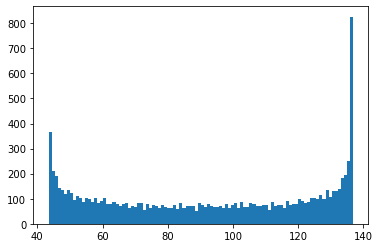

In [38]:
# inputs
inc_orbit = 90 # ±12
Omega_orb = -5 #± 13 ± 180

conv = np.pi/180

# limit
phi_op_lim = np.abs(inc_planet[0]-inc_orbit)
print('phi_op_lim > ',phi_op_lim)

# with a distribution

def phi_op_dist(inc_pl, inc_orbit, Omega_pl, Omega_orb):
    arg_1 = np.cos(inc_pl)*np.cos(inc_orbit) 
    arg_2 = np.sin(inc_pl)*np.sin(inc_orbit)
    
    dist_1 = arg_2*np.cos(Omega_orb-Omega_pl)
    
    phi_op = np.arccos(arg_1 + dist_1)
    return phi_op


Omega_pl_dist = np.random.uniform(low=0.0, high=180, size=10000)
phi_op = phi_op_dist(inc_planet[0]*conv, inc_orbit*conv, Omega_pl_dist*conv, Omega_orb*conv)

plt.hist(phi_op/conv, bins=100)
plt.show()

# vi/ Obliquity Complex

#### Laetitia's help

Size initial sample = 2870
Maximum velocity with P>Pb = 101.37252448138145 km / s
Size new sample = 1477 (vsini < v < vb)


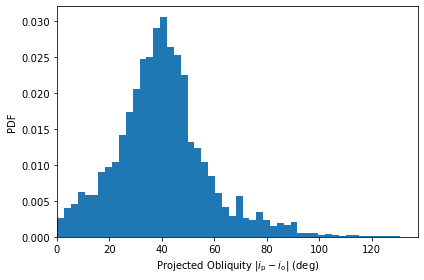

In [23]:
file  = open("/Users/pulux/Desktop/exoAtmospheres/code_exoAtm/data/result_nestle_ABPicb_B7.txt", "r")
data = np.loadtxt(file, skiprows=1)
file.close()

radius = data[:,4]*u.Rjup #km
vsini = data[:,6] * (u.km / u.s)#km/s

p = (2.12*u.hr).to(u.s) #h2s #s
v = (2*np.pi*radius/p).si# km/s

mp = 10*u.Mjup #kg
pb = 2*np.pi*(radius**(3/2))/np.sqrt(c.G*mp) # break-up period (s)

print(f"Size initial sample = {len(v)}")
sample = (p > pb) # Removing solutions above the break-up velocity
vsini = vsini[sample]
v = (v[sample]).to(u.km/u.s)

vmax = v.max()
print(f"Maximum velocity with P>Pb = {vmax}")

sample = (vsini < v)
nsample = np.sum(sample)
print(f"Size new sample = {nsample} (vsini < v < vb)")
sini = vsini/v
ip = np.arcsin(sini[sample])
ip = np.concatenate((ip.value, np.pi-ip.value))
nsample *= 2

file = open("io.dat", "r")
io = np.loadtxt(file, skiprows=1)
file.close()

if len(io) > nsample:
    io = np.random.choice(io, nsample)
else:
    nsample = len(io)
    ip = np.random.choice(ip, nsample)
lambda_no_prior = abs(io-ip) # lambda =  projected obliquity |io-ip|

dr = np.pi/180
plt.hist(lambda_no_prior/dr, bins="auto", density=True)


plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.xlabel(r"Projected Obliquity $|i_{\rm p} - i_{\rm o}|$ (deg)")
plt.ylabel("PDF")

plt.tight_layout()
plt.show()



Size initial sample = 2870
Maximum velocity with P>Pb = 101.37252448138145 km/s
Size initial sample = 1508
Size new sample = 1477 (vsini < v < vb)


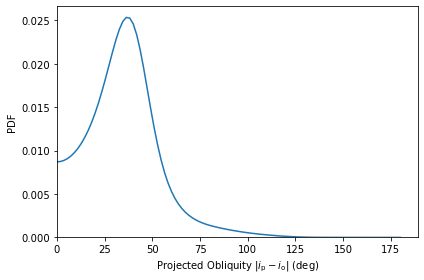

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pyqt_fit import kde,kde_methods
import pickle

G = 6.67e-20 #km**3 kg**-1 s**-2
rjup = 71492 #km
mjup = 1.898e27 #kg
h2s = 3600 #sec
dr = np.pi/180

# filename = 'result_nestle_ABPicb_B7.pic'
#
# with open(filename, 'rb') as f:
#     res  = pickle.load(f)
#     samp = res.samples
#     weig = res.weights
# radius = samp[:,4]*rjup #km
# vsini = samp[:,6] #km/s

file  = open("/Users/pulux/Desktop/exoAtmospheres/code_exoAtm/data/result_nestle_ABPicb_B7.txt", "r")
data = np.loadtxt(file, skiprows=1)
file.close()

radius = data[:,4]*rjup #km
vsini = data[:,6] #km/s

p = 2.12*h2s #s
v = 2*np.pi*radius/p # km/s

mp = 10*mjup #kg
pb = 2*np.pi*(radius**(3/2))/np.sqrt(G*mp) # break-up period (s)

print(f"Size initial sample = {len(v)}")
sample = (p > pb) # Removing solutions above the break-up velocity
vsini = vsini[sample]
v = v[sample]

vmax = v.max()
print(f"Maximum velocity with P>Pb = {vmax} km/s")

lv = kde.KDE1D(v)
lu = kde.KDE1D(vsini)

nv = 1000
vrange = np.linspace(0, vmax, nv)
i = np.linspace(0, np.pi, 100)

pcosi = np.zeros_like(i) # PDF of cos(ip)
for j, ci in enumerate(np.cos(i)):
    int_dv = lv(vrange)*lu(vrange*np.sqrt(1-ci*ci))
    pcosi[j] = np.trapz(int_dv, vrange)

pi = pcosi*np.sin(i) # PDF of ip

int_pi = np.trapz(pi, i) # normalization factor
pi /= int_pi

sample = (vsini < v)
nsample = np.sum(sample)
print(f"Size initial sample = {len(v)}")
print(f"Size new sample = {nsample} (vsini < v < vb)")
sini = vsini/v
ip = np.arcsin(sini[sample])
ip = np.concatenate((ip, np.pi-ip))
nsample *= 2

file = open("io.dat", "r")
io = np.loadtxt(file, skiprows=1)
file.close()

lo = kde.KDE1D(io, lower=0., upper=np.pi, method=kde_methods.cyclic) # PDF of io

### Here I compute proba(l) = proba(|io-ip|) = int pi(ip)*(pio(ip+l)+pio(ip-l))/2 (combination of probability functions)
l = np.linspace(0, np.pi, 100)
pl = np.zeros_like(l)
i = np.linspace(0, np.pi, 100)

def pio(x): # PDF of io, being sure it is defined everywhere (not only [0, pi])
    if np.isscalar(x):
        if (x > 0) and (x < np.pi):
            return(lo(x))
        else:
            return(0)
    else:
        res = np.zeros_like(x)
        for k, xx in enumerate(x):
            if (xx > 0) and (xx < np.pi):
                res[k] = lo(xx)
            else:
                res[k] = 0
        return(res)

for j, la in enumerate(l):
    int_dl = pi*(pio(i-la)+pio(i+la))/2
    pl[j] = np.trapz(int_dl, i)

int_pl = np.trapz(pl, l)
pl /= int_pl

# plot projected obliquity
plt.plot(l/dr, pl*dr, label="prior cos")

plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.xlabel(r"Projected Obliquity $|i_{\rm p} - i_{\rm o}|$ (deg)")
plt.ylabel("PDF")

plt.tight_layout()
plt.show()

In [2]:
3.3 + 6.15 + 1.36+ 6.61 + 5.73 +22.8


45.95

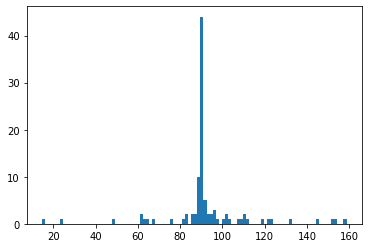

In [44]:
Omega_pl_dist = np.random.uniform(low=0.0, high=180, size=len(pl))
phi_op = phi_op_dist(pl, inc_orbit*conv, Omega_pl_dist*conv, Omega_orb*conv)

plt.hist(phi_op/conv, bins=100)
plt.show()

In [30]:
dr

0.017453292519943295

In [37]:
inc_orbit*conv, pl

(1.5707963267948966,
 array([4.98417511e-01, 5.00763317e-01, 5.07833392e-01, 5.19725806e-01,
        5.36601177e-01, 5.58674758e-01, 5.86215834e-01, 6.19567770e-01,
        6.59173370e-01, 7.05563138e-01, 7.59271662e-01, 8.20686365e-01,
        8.89864466e-01, 9.66338592e-01, 1.04889090e+00, 1.13526811e+00,
        1.22187537e+00, 1.30359959e+00, 1.37396081e+00, 1.42571559e+00,
        1.45187680e+00, 1.44696193e+00, 1.40820471e+00, 1.33643222e+00,
        1.23630282e+00, 1.11568954e+00, 9.84251082e-01, 8.51597606e-01,
        7.25677664e-01, 6.11877706e-01, 5.12931527e-01, 4.29387950e-01,
        3.60294839e-01, 3.03870446e-01, 2.58057998e-01, 2.20907390e-01,
        1.90753403e-01, 1.66223218e-01, 1.46173167e-01, 1.29651353e-01,
        1.15905941e-01, 1.04387995e-01, 9.47018765e-02, 8.65184650e-02,
        7.95115075e-02, 7.33580772e-02, 6.77856152e-02, 6.26123146e-02,
        5.77459993e-02, 5.31508396e-02, 4.88131384e-02, 4.47241352e-02,
        4.08760028e-02, 3.72616255e-02, 3.3